### Makemore Part 2

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
#read in all the words
words = open('names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [4]:
#Building the dataset - very similar to the trigram construction but dynamic

block_size = 3 #alternative for context length

X, Y = [], []

for w in words[:5]:

    print(w, '--- word of interest')
    context = [0] * block_size #How many characters to consider from the left to the right
    for ch in w + '.': #adding end word
        
        ix = stoi[ch]

        X.append(context)
        Y.append(ix)

        print(''.join(itos[i] for i in context), '--->', itos[ix])

        context = context[1:] + [ix] #context is redefined as a new list and we move the window to the right


X = torch.tensor(X)
Y = torch.tensor(Y)

emma --- word of interest
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia --- word of interest
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava --- word of interest
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella --- word of interest
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia --- word of interest
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [5]:
##look up table. 
##The column metric is showing how many "features" are contained within each vector
C = torch.randn((27,2))

#Can execute look ups with single integers (for one character retrieval at a time)
embedding_of_char_5 = C[5]
print(f"Embedding of the char 5: {embedding_of_char_5}")
##Or
#Can execute look ups with lists of integers and/or tensors to retrieve multiple embeddings to begin with
embedding_of_chars_5_6_7 = C[torch.tensor([5,6,7])]

print(f"Embedding of the chars 5,6, and 7: {embedding_of_chars_5_6_7}")

Embedding of the char 5: tensor([0.0125, 0.7028])
Embedding of the chars 5,6, and 7: tensor([[ 0.0125,  0.7028],
        [ 1.3581,  0.0891],
        [-0.8767, -1.7067]])


In [6]:
""" Using the method above we can get C[X] which represents
    the 2 dimensional embeddings for each character stored in the Xn (32 for first 5 words) samples
    of char sequences
"""

' Using the method above we can get C[X] which represents\n    the 2 dimensional embeddings for each character stored in the Xn (32 for first 5 words) samples\n    of char sequences\n'

In [7]:
embedding = C[X]
print(f"embedding shape {embedding.shape}")

embedding shape torch.Size([32, 3, 2])


In [8]:
print(f"10th sample is chars: {X[10]}")

10th sample is chars: tensor([ 9, 22,  9])


In [9]:
print(f"Embedding for the 10th sample should be dims(3 x2): {embedding[10]}")
print("This is showing the 2d embding representation of the characters in tensor above")

Embedding for the 10th sample should be dims(3 x2): tensor([[-0.9536, -1.3009],
        [ 0.0694,  1.1852],
        [-0.9536, -1.3009]])
This is showing the 2d embding representation of the characters in tensor above


In [10]:
W1 = torch.randn((6, 100)) #100 neurons [weights to be tuned]
b1 = torch.randn(100)

In [ ]:
#embedding[0] -> first example /trigram subset "...", "..e", ".em"
#embedding[0, 0,:] -> first 2 dimensional vector representation of the first character in the trigram subset
#embedding[0,0,0] -> first vector value of 2D vector rep of the first character in the first example subset

In [12]:
embedding[:,0,:].shape #the first char of all Xn samples and it's full vector representation

torch.Size([32, 2])

In [13]:
#Now we concatenate embeddings of the different subsets to be one tensor for multiplication against the weights
#torch.cat([embedding[:,0,:], embedding[:,1,:], embedding[:,2,:]],1).shape

#Can also use
#torch.cat(torch.unbind(embedding,1),1).shape 
"""
#unbind removes a tensor dimension and returns a tuple of all slices along the dimension. 
# So here we are removing the 1th dimensionand returning all the tuples that were within that. 
# So here that would be collecting all character embedding groups per char into separate tensors for easier concatenation
"""
#Can also use view() which forces pytorch to change the view of the embedding to match input dimensions
#embedding.view(32,6)

#embedding.view(32,6) == torch.cat(torch.unbind(embedding,1),1), "Double check your array manipulation" #proving that the embeddng view and cat + unbind methods



'\n#unbind removes a tensor dimension and returns a tuple of all slices along the dimension. \n# So here we are removing the 1th dimensionand returning all the tuples that were within that. \n# So here that would be collecting all character embedding groups per char into separate tensors for easier concatenation\n'

#### Hidden Layer creation

In [14]:
#Creating the hidden layer
h = embedding.view(embedding.shape[0],6) @ W1 + b1 

tanh = torch.tanh(h) #activation function

In [15]:
tanh.shape

torch.Size([32, 100])

#### Now create the output layer

In [16]:
W2 = torch.randn([100,27]) #27 possible characters coming out
b2 = torch.randn(27)

In [17]:
#Creating logits in final layer
logits = tanh @ W2 + b2
print(logits.shape)



torch.Size([32, 27])


#### Now create the probabilistic output using softmax

In [18]:
#exponenize the logits to make everything positive
counts = logits.exp()

#calculate probabilities
probs = counts/counts.sum(1, keepdims = True)

In [19]:
#2nd method
probs_torch_softmax = torch.softmax(logits, 1)

In [20]:
#We want to index into prob and pluck out the highest predicted next character for all Xn samples
#For all Xn samples, we gather the index listed in Y so for Xn1, we gather the first classification expected character
loss = -probs[torch.arange(32), Y].log().mean()

In [21]:
loss_torch_softmax = -probs_torch_softmax[torch.arange(X.shape[0]), Y].log().mean()

### reproducibility time!

In [22]:
Y.shape

torch.Size([32])

In [23]:
#Building the dataset - very similar to the trigram construction but dynamic

block_size = 3 #alternative for context length

X, Y = [], []

for w in words:

    #print(w, '--- word of interest')
    context = [0] * block_size #How many characters to consider from the left to the right
    for ch in w + '.': #adding end word
        
        ix = stoi[ch]

        X.append(context)
        Y.append(ix)

        #print(''.join(itos[i] for i in context), '--->', itos[ix])

        context = context[1:] + [ix] #context is redefined as a new list and we move the window to the right


X = torch.tensor(X)
Y = torch.tensor(Y)

In [24]:
##LEts make it reproducible
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100,27), generator = g)
b2 = torch.randn(27, generator = g)

parameters = [C, W1, b1, W2, b2]

# embeddings = C[X]
# tanh = torch.tanh(embedding.view(embedding.shape[0],6) @ W1 + b1)#can also use embedding.view(-1,6)
# logits = tanh @ W2 + b2
# counts = logits.exp()
# probs = counts / counts.sum(1, keepdim=True)
# loss_deprec = -probs[torch.arange(X.shape[0]), Y].log().mean()
# print(f"current loss: {loss_deprec}")

In [25]:

for p in parameters:
    print(p.shape, '--- shape')
    
    p.requires_grad = True

torch.Size([27, 2]) --- shape
torch.Size([6, 100]) --- shape
torch.Size([100]) --- shape
torch.Size([100, 27]) --- shape
torch.Size([27]) --- shape


In [26]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [27]:
## training loop 
learning_rate = -0.1

for _ in range(100):

    ix = torch.randint(0,X.shape[0], (32,))
    
    embeddings = C[X[ix]] #only get 32 samples
    tanh = torch.tanh(embeddings.view(embeddings.shape[0],6) @ W1 + b1)#can also use embedding.view(-1,6)
    logits = tanh @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    #print(f"current loss: {loss.item()}")

    for p in parameters:
        p.grad = None

    loss.backward()

    for p in parameters:
        if p.grad is not None:
            pass
        else:
            print(p.shape, '--- missing grad')

    for p in parameters:
        p.data += learning_rate * p.grad


print(f"current loss: {loss.item()}")

current loss: 3.1851646900177


In [28]:
##Now lets look at the overall  performance
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h@W2 + b2
cross_ent = F.cross_entropy(logits, Y)

In [29]:
print(cross_ent)

tensor(3.7261, grad_fn=<NllLossBackward0>)


In [30]:
##Create train, dev/val,test
import random
#read in all the words
words = open('names.txt', 'r').read().splitlines()
random.shuffle(words)

chars = sorted(list(set(''.join(words))))
stoi = {s:i for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

#Building the dataset - very similar to the trigram construction but dynamic
def prepare_data(data, block_size):

    block_size = block_size #alternative for context length

    X, Y = [], []

    for w in words:

        #print(w, '--- word of interest')
        context = [0] * block_size #How many characters to consider from the left to the right
        for ch in w + '.': #adding end word
            
            ix = stoi[ch]

            X.append(context)
            Y.append(ix)

            #print(''.join(itos[i] for i in context), '--->', itos[ix])

            context = context[1:] + [ix] #context is redefined as a new list and we move the window to the right


    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

train_limit = int(0.8*len(words))
dev_limit = int(0.9*len(words))

Xtr, Ytr = prepare_data(words[:train_limit], block_size = 3)
Xdev, Ydev = prepare_data(words[train_limit:dev_limit], block_size = 3)
Xtest, Ytest = prepare_data(words[dev_limit:], block_size = 3)

### Lets try increasing the size of the neural network

In [31]:
assert Xtr.shape[0] == Ytr.shape[0], "make sure split works"

In [32]:
##LEts make it reproducible
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,300), generator = g)
b1 = torch.randn(300, generator = g)
W2 = torch.randn((300,27), generator = g)
b2 = torch.randn(27, generator = g)

parameters = [C, W1, b1, W2, b2]


In [33]:
print(f"Numer of paramters: {sum(p.nelement() for p in parameters)}")

Numer of paramters: 17697


In [34]:

for p in parameters:
    print(p.shape, '--- shape')
    
    p.requires_grad = True

torch.Size([27, 10]) --- shape
torch.Size([30, 300]) --- shape
torch.Size([300]) --- shape
torch.Size([300, 27]) --- shape
torch.Size([27]) --- shape


In [35]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [36]:
## training loop 
lri = []
lossi = []
stepi = []

for _ in range(50000):

    ix = torch.randint(0,Xtr.shape[0], (32,))
    
    embeddings = C[Xtr[ix]] #only get 32 samples
    tanh = torch.tanh(embeddings.view(embeddings.shape[0],30) @ W1 + b1)#can also use embedding.view(-1,6)
    logits = tanh @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    #print(f"current loss: {loss.item()}")

    for p in parameters:
        p.grad = None

    loss.backward()

    # for p in parameters:
    #     if p.grad is not None:
    #         pass
    #     else:
    #         print(p.shape, '--- missing grad')
    #lr = lrs[_]
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
        
    #lri.append(lre[_])
    lossi.append(loss.log10().item())
    stepi.append(_)


print(f"current loss: {loss.item()}")

current loss: 2.416490316390991


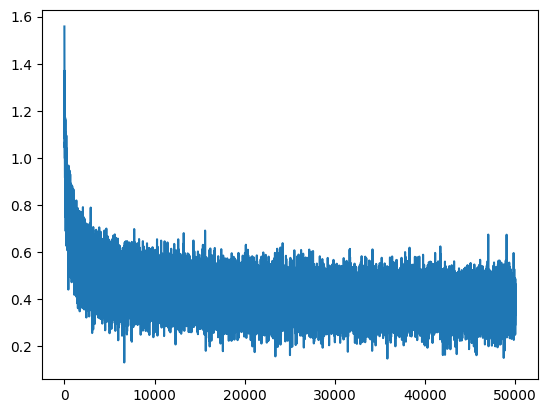

In [37]:
#plt.plot(lri, lossi) -> identifying valley for lowest losses per learning rate
plt.plot(stepi, lossi) #Tells where loss may be hitting a local minima

In [38]:
##Now lets look at the overall  performance
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h@W2 + b2
cross_ent = F.cross_entropy(logits, Ytr)
print(f"XDev: {cross_ent})")

XDev: 2.6030662059783936)


In [39]:
##Now lets look at the overall  performance
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h@W2 + b2
cross_ent = F.cross_entropy(logits, Ydev)

In [40]:
print(cross_ent)


tensor(2.6031, grad_fn=<NllLossBackward0>)


In [41]:
##Now lets look at the overall  performance
emb = C[Xtest]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h@W2 + b2
print(f"Test score: {F.cross_entropy(logits, Ytest)}")

Test score: 2.6030662059783936


KeyError: 26

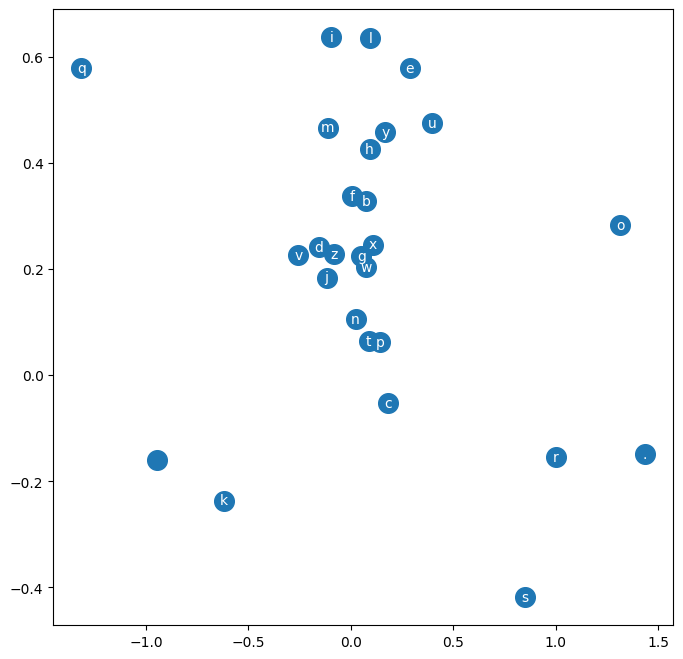

In [42]:
#lets look at the embeddings

plt.figure(figsize = (8,8))
plt.scatter(C[:, 0].data, C[:,1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i, 1].item(), itos[i], ha = "center", va = "center", color = "white")
plt.grid("minor")

#Things to try:
    - change neurons
    -change embeddings dimension
    -change number of characters
    -change learning ratte

### Sampling from the model


In [43]:
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3
for _ in range(40):
    
    out = []
    context = [0] * block_size
    while True:
        embedding = C[torch.tensor([context])]

        h = torch.tanh(embedding.view(1, -1) @ W1 + b1) #We use (1,-1) to have pytorch infer the correct tensor size

        logits = h @W2 + b2

        probs = F.softmax(logits, dim =1)

        ix = torch.multinomial(probs, num_samples = 1, generator = g).item() #gather a probability using multinomial distribution

        context = context[1:] + [ix]

        out.append(ix)

        if ix == 0:
            break


    print("".join(itos[i] for i in out))

frishinoberiel.
noe.
hiliph.
rist.
kle.
rhlyne.
krelimijitldelilipe.
jovelyy.
sofim.
drioriy.
oktish.
shylenorilli.
k.
roldiryouridgov.
dhoreliy.
rivennie.
lelinet.
lviouily.
dley.
rovillelimillison.
shlle.
klilliogier.
groyniy.
idh.
delissieliy.
kinsley.
jenrpyn.
dwilyxilli.
jelison.
uriel.
jelizee.
hriylitt.
sheliy.
deliyreniy.
ybriy.
ilv.
dellillison.
khe.
kelie.
kilenderideneldynno.
